# FAIRStream Case Studies

This toturial is a gallery of multiple cases of Medical AI using FAIRStream to make prediction on multivariate time series data from NICU infants might associated with unfavorable respiratory events, and ICU adult patient might associated with bloodstream infection events.

- Make the predictions all at once
    - forecast 1 step on 1 numeric variable
    - forecast >1 steps on 1 numeric variable
    - forecast 1 categorical variable (classification)
- Autoregressive prediction

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

## Case 1

In this case study, we deal with **hourly prediction**. We will use 3 types of deep learning models to forecast next hour's periodic breathing burden index of preterm NICU patients, using vital signs hourly statistics </br>

Input

> * hourly mean, std, skewness, kurtosis of Heart Rate
> * hourly mean, std, skewness, kurtosis of SPO2 percentage

Output 
> * 1 hour Periodic Breathing Burden Index in the future

Regression strategy
> * 10 fold bootstrapping study subjects for model validation 
> * train, test datasets split by subject
> * anchor_gap = 5(minimum length of an episode set to be 5 hours for computational efficiency)

### Linear Regression

Linear model is to predict period breathing burden index 1h in the future given the current value of inputs (1 hour).

In [ ]:
# set up
# 1. create a fairstream instance
prvt_stream = FAIRStream.FAIRStream('../project1_hourly')# windows
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=1, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=5)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.CosineSimilarity(axis=1)
]

# 10 fold bootstrap
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=300, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    linear = keras.models.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Dense(1*1)
    ])
    linear.summary()

    # compile and run the model
    linear.compile(loss=tf.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=10)
    his =linear.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(linear.optimizer.learning_rate, 1e-4)
    his = linear.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(linear.optimizer.learning_rate, 1e-5)
    his = linear.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    keras.backend.set_value(linear.optimizer.learning_rate, 1e-6)
    his = linear.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

Visualize model evaluation matices 
(blue=train,orange=valid)

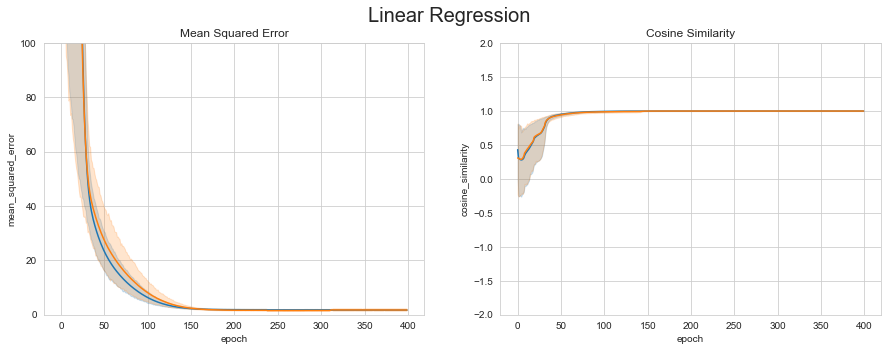

In [4]:
#eval_df_trace_folds.to_csv('../project1_hourly/report/eval_mtrx_case1_linear.csv', index=False)
data = pd.read_csv('../project1_hourly/report/eval_mtrx_case1_linear.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Linear Regression', fontsize=20)
axs = axs.flatten()
mtrx = 'mean_squared_error'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
axs[0].set_ylim(0,100)
axs[0].set_title('Mean Squared Error')
mtrx = 'cosine_similarity'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
axs[1].set_ylim(-2,2)
axs[1].set_title('Cosine Similarity')
plt.show();

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input.

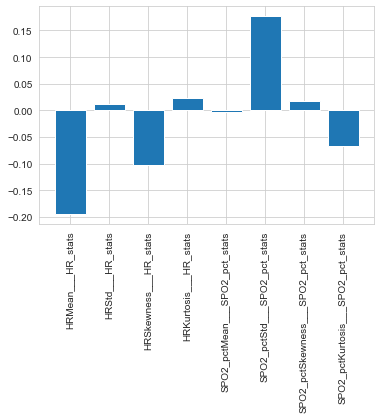

In [5]:
plt.bar(x = range(len(prvt_stream.engineer.input_vars)), height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(prvt_stream.engineer.input_vars)))
_ = axis.set_xticklabels(prvt_stream.engineer.input_vars, rotation=90)

### CNN (Multi-step inputs)

Now we will use 24 hours of inputs to predict output 1 step in the future 

In [ ]:
# set up
# 1. create a fairstream instance
prvt_stream = FAIRStream.FAIRStream('../project1_hourly')# windows
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=5)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.CosineSimilarity(axis=1)
]

# 10 fold bootstrap
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=300, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    cnn = keras.models.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        #keras.layers.Dropout(0.3), # to prevent overfitting
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(1*1),
        tf.keras.layers.Reshape([1, -1])# Add back the time dimension. Shape: (outputs) => (1, outputs)
    ])
    cnn.summary()

    # compile and run the model
    cnn.compile(loss=tf.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=5)
    his = cnn.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(cnn.optimizer.learning_rate, 1e-4)
    his = cnn.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(cnn.optimizer.learning_rate, 1e-5)
    his = cnn.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(cnn.optimizer.learning_rate, 1e-6)
    his = cnn.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

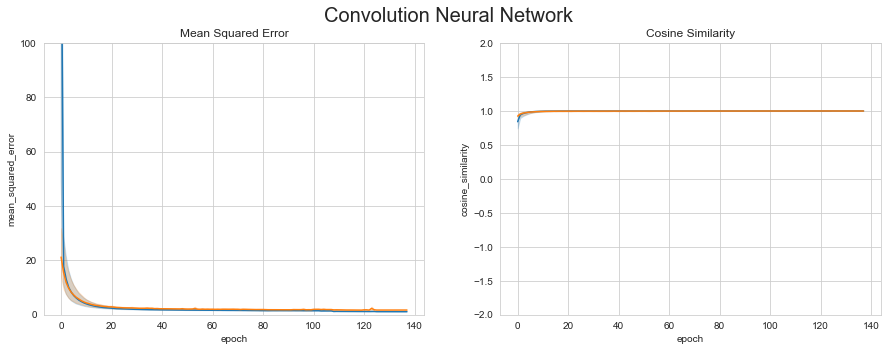

In [7]:
eval_df_trace_folds.to_csv('../project1_hourly/report/eval_mtrx_case1_cnn.csv', index=False)
data = pd.read_csv('../project1_hourly/report/eval_mtrx_case1_cnn.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Convolution Neural Network', fontsize=20)
axs = axs.flatten()
mtrx = 'mean_squared_error'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
axs[0].set_ylim(0,100)
axs[0].set_title('Mean Squared Error')
mtrx = 'cosine_similarity'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
axs[1].set_ylim(-2,2)
axs[1].set_title('Cosine Similarity')
plt.show();

### RNN - LSTM

Success: Querier has initiated a csv source dictionary in:../project1_hourly/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:../project1_hourly/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
 
Success! An episode is - 
    - predicting 1 hours outputs into the future
    - using 24 hours long inputs with 0 hours lag from the last input observation
    - increasing by every 1 hours
    - at least 5 hours apart from the previous episode
 
--- Fix upper boudary for SPO2_pctMean by 100.0
--- Fix lower boudary for SPO2_pctMean by 5.0
--- Fix upper boudary for SPO2_pctStd by 100.0
--- Fix lower boudary for SPO2_pctStd by 0.0
--- Fix upper boudary for SPO2_pctSkewness by 41.507764
--- Fix lower boudary for SPO2_pctSkewness by -59.177701
--- Fix upper boudary for SPO2_pctKurtosis by 100.0
--- Fix lower boudary for SPO2_pctKurtosis by 1.0
--- Fix upper boudary for __anchor by 

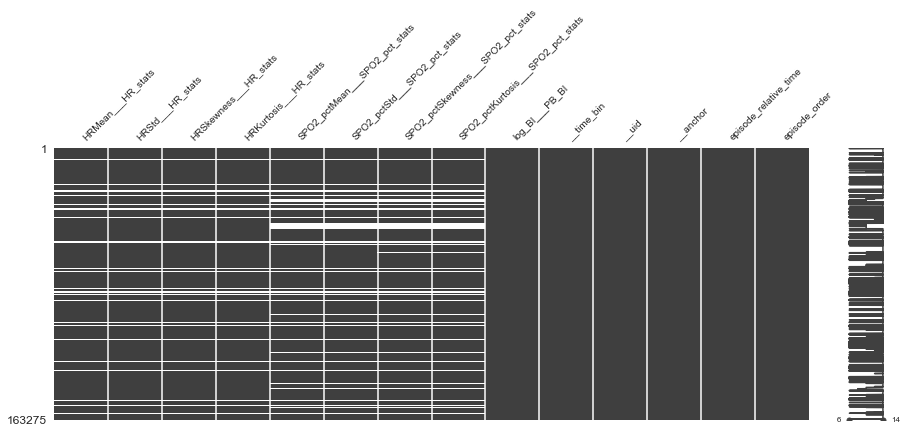

--- Validation MVTS DF missingness before imputation


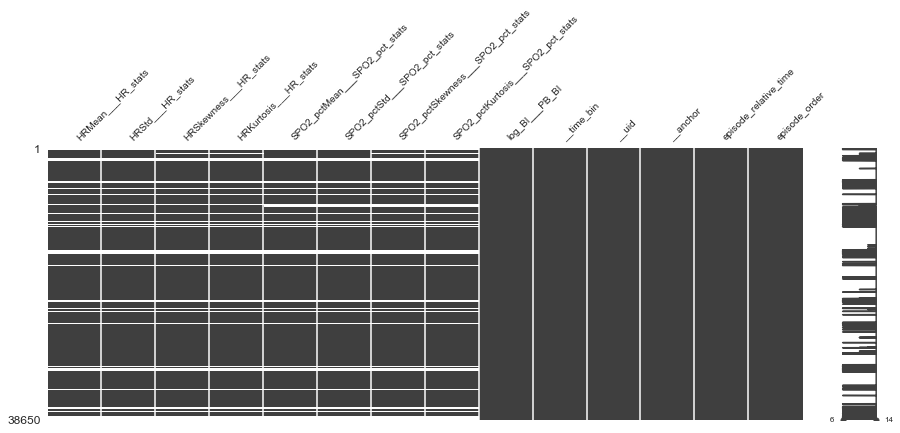

--- Training MVTS DF missingness after imputation


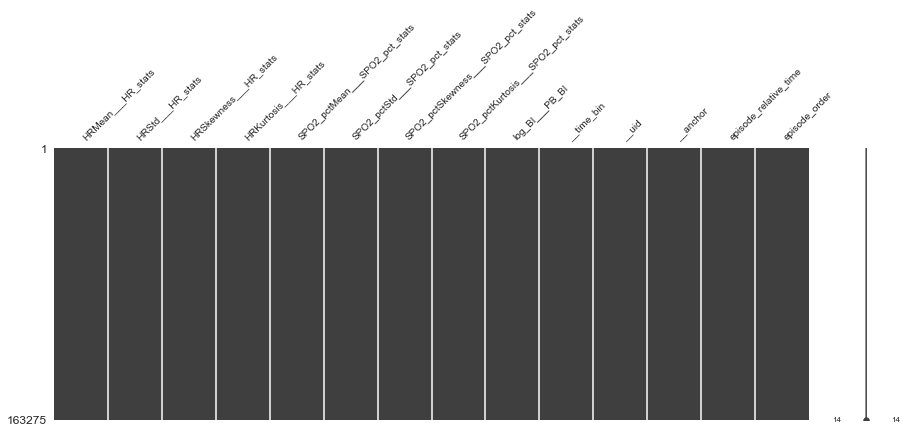

--- Validation MVTS DF missingness after imputation


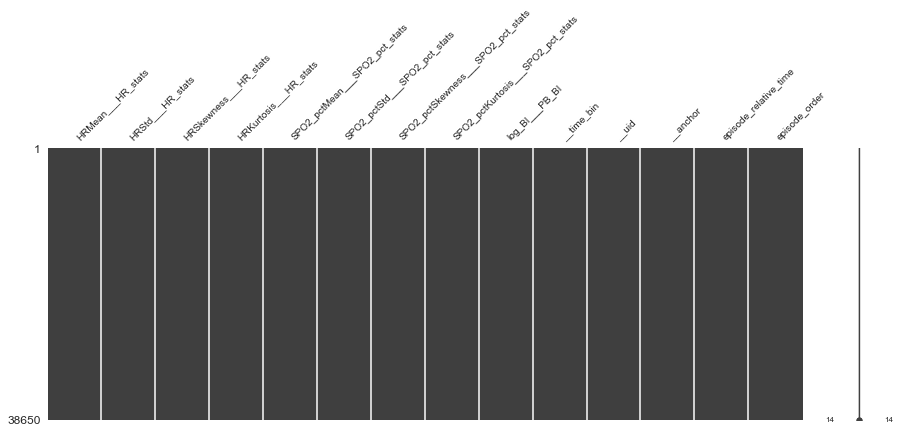

Success! Engineer has two new attributes train_df_imputed and valid_df_imputed. 
Success! Engineer has new attributes train_tfds_imputed and valid_tfds_imputed. 
 

--------------------------------- Engineer Attributes List -------------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'episode', 'sample_info', 'mvts_df', 'mvts_tfds', 'input_vars', 'output_vars', 'train_df', 'valid_df', 'train_df_imputed', 'valid_df_imputed', 'train_tfds_imputed', 'valid_tfds_imputed']

----------------------------------------- Inputs -----------------------------------------

['HRMean___HR_stats', 'HRStd___HR_stats', 'HRSkewness___HR_stats', 'HRKurtosis___HR_stats', 'SPO2_pctMean___SPO2_pct_stats', 'SPO2_pctStd___SPO2_pct_stats', 'SPO2_pctSkewness___SPO2_pct_stats', 'SPO2_pctKurtosis___SPO2_pct_stats']

----------------------------------------- Outputs ----------------------------------------

['log_BI___PB_BI']

------------------------------------- M

In [2]:
# set up
# 1. create a fairstream instance
prvt_stream = FAIRStream.FAIRStream('../project1_hourly')# windows
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=5)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.CosineSimilarity(axis=1)
]

# 10 fold bootstrap
for i in range(1):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=300, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    lstm = keras.models.Sequential([
        keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        keras.layers.Dense(1*1)
    ])
    lstm.summary()

    # compile and run the model
    lstm.compile(loss=tf.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=10)
    his =lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-4)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-5)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-6)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    

    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)